**Load Dependencies**


In [132]:
import tensorflow as tf
import numpy as np
import json
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dropout, Dense
from tensorflow.keras.layers import Flatten

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


**Load Marsyas MFCC Dataset**


In [2]:
file_path = "data/mfcc_gtzan10.json"

with open(file_path, "r") as f:
    data = json.load(f)

**Transforms Labels and MFCCs to Numpy Arrays**

In [8]:
X = np.array(data['mfcc'])
y = np.array(data['labels'])
len(X)


9996

**Split Data Set Into Training, Validation and Testing Sets**


In [11]:
TEST_SIZE = 0.25
VALIDATION_SIZE = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE)
# Subdivide Training Set Into Validation and Training Set 
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=VALIDATION_SIZE)

X_train = X_train[..., np.newaxis]
X_validation = X_validation[..., np.newaxis]
X_test = X_test[..., np.newaxis]


5997
1500
2499


In [14]:
print(X_train.shape)
print(X_train.shape[1])
print(X_train.shape[2])

(5997, 130, 13, 1)
130
13


**Construct CNN** 

In [127]:

input_shape = (X_train.shape[1], X_train.shape[2],1)
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same'))

model.add(Conv2D(64, (2, 2), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same'))
model.add(Dropout(0.2))

model.add(Conv2D(128, (1, 1), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same'))
model.add(Dropout(0.2))

model.add(Conv2D(256, (1, 1), activation='relu'))
model.add(MaxPool2D(pool_size=(1, 1), strides=(2, 2), padding='same'))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(10, activation='softmax'))

BATCH_SIZE = 10
EPOCHS = 50

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, mode='auto')

model.compile(loss='sparse_categorical_crossentropy',optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'] )

model.summary()


Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_163 (Conv2D)          (None, 128, 11, 32)       320       
_________________________________________________________________
max_pooling2d_163 (MaxPoolin (None, 64, 6, 32)         0         
_________________________________________________________________
batch_normalization_68 (Batc (None, 64, 6, 32)         128       
_________________________________________________________________
conv2d_164 (Conv2D)          (None, 62, 4, 64)         18496     
_________________________________________________________________
max_pooling2d_164 (MaxPoolin (None, 31, 2, 64)         0         
_________________________________________________________________
conv2d_165 (Conv2D)          (None, 30, 1, 64)         16448     
_________________________________________________________________
max_pooling2d_165 (MaxPoolin (None, 15, 1, 64)       

**Fit Model Over Training Set**


In [128]:
history = model.fit(X_train, y_train, validation_data=(X_test,y_test), batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=([reduce_lr,early_stopping])) 


Train on 5997 samples, validate on 2499 samples
Epoch 1/50
5997/5997 [==============================] - 4s 610us/sample - loss: 2.0847 - accuracy: 0.2465 - val_loss: 1.7200 - val_accuracy: 0.3834
Epoch 2/50
5997/5997 [==============================] - 3s 480us/sample - loss: 1.6860 - accuracy: 0.3899 - val_loss: 1.4162 - val_accuracy: 0.5006
Epoch 3/50
5997/5997 [==============================] - 3s 464us/sample - loss: 1.5133 - accuracy: 0.4506 - val_loss: 1.3149 - val_accuracy: 0.5358
Epoch 4/50
5997/5997 [==============================] - 3s 476us/sample - loss: 1.4225 - accuracy: 0.4852 - val_loss: 1.2261 - val_accuracy: 0.5490
Epoch 5/50
5997/5997 [==============================] - 3s 464us/sample - loss: 1.3662 - accuracy: 0.5183 - val_loss: 1.1643 - val_accuracy: 0.5822
Epoch 6/50
5997/5997 [==============================] - 3s 468us/sample - loss: 1.2900 - accuracy: 0.5434 - val_loss: 1.1109 - val_accuracy: 0.6018
Epoch 7/50
5997/5997 [==============================] - 3s 467us

**Evaluate Model Accuracy**


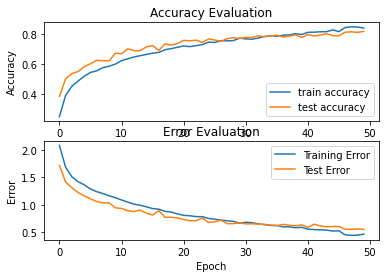

In [129]:

fig, axis = plt.subplots(2)

axis[0].plot(history.history['accuracy'], label="train accuracy")
axis[0].plot(history.history['val_accuracy'], label="test accuracy")
axis[0].set_ylabel("Accuracy")
axis[0].legend(loc="lower right")
axis[0].set_title("Accuracy Evaluation")

axis[1].plot(history.history['loss'], label="Training Error")
axis[1].plot(history.history['val_loss'], label="Test Error")
axis[1].set_ylabel("Error")
axis[1].set_xlabel("Epoch")
axis[1].legend(loc="upper right")
axis[1].set_title("Error Evaluation")

plt.show()


**Accuracy Score**

In [133]:

predictions = model.predict_classes(X_test)
print("Accuracy: {}".format(round(accuracy_score(y_test,predictions)*100,2)))


Accuracy: 81.87


**Confusion Matrix**


In [135]:
conf_matrix = confusion_matrix(y_test, predictions)
print("Confusion Matrix: \n", conf_matrix)
print("Classification Report: \n", classification_report(y_test, predictions))


Confusion Matrix: 
 [[234   0   9   5   1  12   4   0   5   4]
 [  1 247   3   0   0   6   0   1   0   0]
 [  9   0 173   2   0  12   1   7   6  17]
 [  3   2   2 219  12   0   3  10  11  13]
 [  5   0   0   7 209   3   6   9   7   2]
 [  2  11   7   1   0 205   1   1   3   1]
 [  3   0   2   1   6   0 236   0   2  11]
 [  0   0  12   3   3   0   0 202   6   8]
 [  1   0   8  13  23   2   0   7 168   5]
 [ 16   3  24  21   7   7  17   5  10 153]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.85      0.85      0.85       274
           1       0.94      0.96      0.95       258
           2       0.72      0.76      0.74       227
           3       0.81      0.80      0.80       275
           4       0.80      0.84      0.82       248
           5       0.83      0.88      0.86       232
           6       0.88      0.90      0.89       261
           7       0.83      0.86      0.85       234
           8       0.77      0.74    

**Observations:** We can observe that our model was very accurate at classifying classical music and exceeded human-accuracy for all genres except rock. That is understandable given its similarities with genres such as metal and pop. Reducing the number of segments extracted per audio track may have improved the general accuracy of the model. 

**Save Model**


In [136]:
MODEL_DIR = "./models/music_genre_cnn.hdf5"
print("Saving Model In: " + MODEL_DIR)
tf.keras.models.save_model(model,MODEL_DIR,overwrite=True)


Saving Model In: ./models/music_genre_cnn.hdf5
